# Fraudulent Transaction Classifier
---
We try to use 3 weeks of fraud probability data to build a Machine Learning model and classify all fraudulent transactions.

### 1. Datasets
We begin by loading our dataset onto the Jupyter Notebook and make our `fraud_probability` column

In [1]:
from pyspark.sql import SparkSession, Window, functions as F

# Create a spark session
spark = (
    SparkSession.builder.appName("BNPL Project")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.driver.memory", "8g")
    .config("spark.driver.executor", "8g")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)

p = lambda x,type : f'../../data/{type}/{x}'

22/10/09 15:26:54 WARN Utils: Your hostname, Shromanns-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.12.131.179 instead (on interface en0)
22/10/09 15:26:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/09 15:26:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/09 15:26:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
sdf = spark.read.parquet(p('process_data.parquet', 'curated'), header=True)

# Create Joint Probability of Fraud Transactions
# sdf = sdf.withColumn('fraud_probability', F.col('user_fraud_probability') * F.col('merchant_fraud_probability'))
sdf.limit(10)

merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,merchant_fraud_prediction,user_fraud_prediction
31585975447,1656,8913,51.28,00001f53-b987-4b4...,2021-07-24,NSW,1163,Male,Dolor Dapibus Gra...,digital goods: bo...,b,0.0312,retail_and_wholes...,household_goods_r...,null,null,31499,28552.0,70738.0,2.01971729E9,28339.0,31.0,0.2977922878734449,0.16648824597751838
21025433654,497662,15797,5.84,00004dfd-5e01-408...,2021-11-26,WA,6228,Male,Lorem Foundation,digital goods: bo...,a,0.0655,retail_and_wholes...,household_goods_r...,null,null,3266,2023.0,60415.0,1.22219664E8,49925.0,48.0,0.2820295845552957,0.15614084770266407
91923722701,681639,4694,0.36,0000a01b-53f2-4f6...,2022-05-07,NSW,2158,Female,Euismod Urna Inst...,tent and awning s...,b,0.0505,retail_and_wholes...,department_stores,null,null,22545,14289.0,84223.0,1.203458028E9,54884.0,47.0,0.2768976061824263,0.13292908973901094
40646162173,643439,3260,5.72,0000b108-2dfa-488...,2022-04-18,WA,6155,Female,Mauris Inc.,"cable, satellite,...",c,0.0294,info_media_and_te...,null,null,null,43353,25261.0,82029.0,1.628989984E9,54081.0,44.333333333333336,0.2804949137531262,0.1676907744298789
64403598239,804418,15618,69.08,0000bd8d-0021-418...,2022-08-13,SA,5158,Male,Lobortis Ultrices...,music shops - mus...,a,0.0631,retail_and_wholes...,department_stores,null,null,37268,22626.0,57968.333333333336,1.310262977E9,53277.333333333336,44.0,0.2844881058676506,0.17548235039030963
60111071436,101872,22134,129.51,00013a8d-3d1e-40d...,2021-10-11,QLD,4357,Male,Imperdiet Non LLC,"cable, satellite,...",a,0.0684,info_media_and_te...,null,null,null,7482,4086.0,43661.0,1.77649122E8,39343.5,46.0,0.28084658762566556,0.19456529896865238
55828706874,1275714,8914,313.78,00015101-b2d5-42c...,2021-04-25,WA,6055,Female,Eget Venenatis A ...,music shops - mus...,a,0.0687,retail_and_wholes...,department_stores,null,null,97517,50162.0,63845.8,3.1775621E9,55556.4,39.0,0.2799937095204423,0.14534925524035827
49891706470,1257196,1604,21.55,000198f8-6855-4c7...,2021-05-13,SA,5640,Male,Non Vestibulum In...,tent and awning s...,a,0.058,retail_and_wholes...,department_stores,null,null,4296,2344.0,51198.0,1.20007795E8,43117.0,48.0,0.6454048668313661,0.1625802483439006
64403598239,1329975,2786,60.47,0001d0a1-1e10-48f...,2022-08-14,NSW,2336,Female,Lobortis Ultrices...,music shops - mus...,a,0.0631,retail_and_wholes...,department_stores,null,null,8448,4341.0,54531.0,2.36717978E8,46601.0,45.0,0.2821937813076115,0.1517941620401105
64403598239,1301003,21018,56.28,0001d1c5-1e4b-47a...,2021-12-27,TAS,7017,Female,Lobortis Ultrices...,music shops - mus...,a,0.0631,retail_and_wholes...,department_stores,null,null,14916,7568.0,54270.0,4.23766641E8,50905.666666666664,40.666666666666664,0.2821937813076115,0.187886695803081


<AxesSubplot:xlabel='rate', ylabel='dollar_value'>

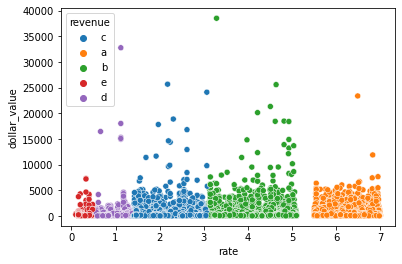

In [4]:
import seaborn as sns

df = sdf.select('revenue', 'rate', 'dollar_value').sample(0.01).toPandas()

sns.scatterplot(data=df, x='rate', y='dollar_value', hue='revenue')

- user: *dollar_value* deviations
- merchant: *take_rate* deviations

In [5]:
print('missing user_fraud_probability count:', sdf.where(F.col('user_fraud_probability').isNull()).count())
print('missing merchant_fraud_probability count:', sdf.where(F.col('merchant_fraud_probability').isNull()).count())

missing user_fraud_probability count: 2581301
missing merchant_fraud_probability count: 13030611


array([[<AxesSubplot:title={'center':'user_fraud_probability'}>]],
      dtype=object)

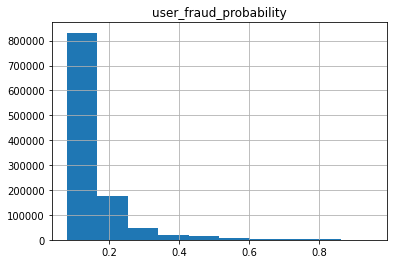

In [6]:
sdf.select(F.col('user_fraud_probability')).sample(0.1).toPandas().hist()

array([[<AxesSubplot:title={'center':'merchant_fraud_probability'}>]],
      dtype=object)

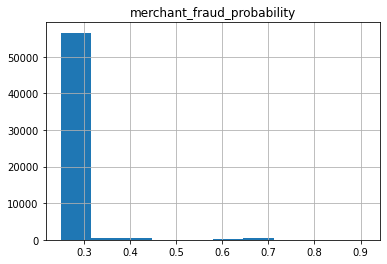

In [7]:
sdf.select(F.col('merchant_fraud_probability')).sample(0.1).toPandas().hist()

array([[<AxesSubplot:title={'center':'fraud_probability'}>]], dtype=object)

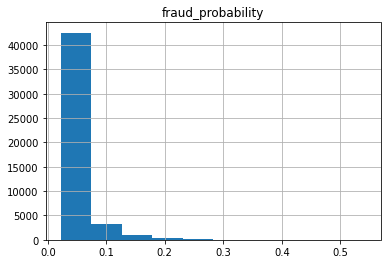

In [8]:
sdf.select(F.col('fraud_probability')).sample(0.1).toPandas().hist()

<AxesSubplot:ylabel='Frequency'>

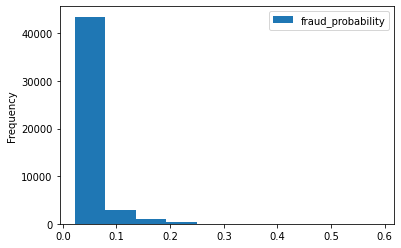

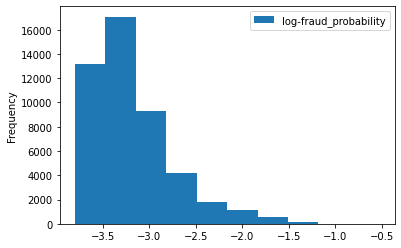

In [9]:
from math import log

sdf.select(F.col('fraud_probability')).sample(0.1).toPandas().plot(kind='hist')
sdf.select(F.col('fraud_probability')).sample(0.1).toPandas()\
    .applymap(log)\
    .rename({'fraud_probability': 'log-fraud_probability'}, axis=1)\
    .plot(kind='hist')

### 2. Modelling
We will use a specific predictors to help train the fraud detector.

In [10]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler, StringIndexer

In [11]:
features = ['merchant_abn',
    'user_id',
    'dollar_value',
    'postcode',
    'gender',
    'tag',
    'revenue',
    'rate',
    'category',
    'subcategory',
    'estimated_region_population_2021_sum',
    'persons_earners_2018-19_sum',
    'mean_earnings_2018-19_avg',
    'sum_earnings_2018-19_sum',
    'median_earnings_2018-19_avg',
    'med_age_earners_2018-19_avg']

label = 'fraud_probability'

In [12]:
categorical = ['postcode', 'state', 'merchant_abn', 'user_id', 'revenue', 'gender', 'tag', 'category', 'subcategory']

for c in categorical:
    v = StringIndexer(inputCol=c, outputCol=f'{c}_i', handleInvalid='skip')
    model = v.fit(sdf)
    sdf = model.transform(sdf).drop(c).withColumnRenamed(f'{c}_i', c)


22/10/03 11:19:03 WARN DAGScheduler: Broadcasting large task binary with size 1007.6 KiB


22/10/03 11:19:05 WARN DAGScheduler: Broadcasting large task binary with size 1000.8 KiB
22/10/03 11:19:05 WARN DAGScheduler: Broadcasting large task binary with size 1011.9 KiB


22/10/03 11:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1003.9 KiB
22/10/03 11:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1016.1 KiB


22/10/03 11:19:12 WARN DAGScheduler: Broadcasting large task binary with size 1007.0 KiB
22/10/03 11:19:12 WARN DAGScheduler: Broadcasting large task binary with size 1021.9 KiB


22/10/03 11:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1011.6 KiB
22/10/03 11:19:16 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB


22/10/03 11:19:20 WARN DAGScheduler: Broadcasting large task binary with size 1014.9 KiB


In [13]:
features_model = VectorAssembler(inputCols=features, outputCol='features', handleInvalid='skip')
sdf = features_model.transform(sdf)

In [14]:
sdf = sdf.withColumn('label', F.when(((F.col('merchant_fraud_probability') > 0.5) & (F.col('user_fraud_probability') > 0.5)), 1).otherwise(0))
sdf

22/10/03 11:19:21 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
22/10/03 11:19:21 WARN DAGScheduler: Broadcasting large task binary with size 1222.8 KiB
22/10/03 11:19:21 WARN DAGScheduler: Broadcasting large task binary with size 1222.8 KiB


consumer_id,dollar_value,order_id,order_datetime,merchant_name,rate,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,fraud_probability,postcode,state,merchant_abn,user_id,revenue,gender,tag,category,subcategory,features,label
1195503,366.23,a8514aae-18fb-454...,2021-11-17,Placerat Orci Ins...,2.73,0.29407407407407304,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.029407407407407306,169.0,2.0,87.0,20960.0,2.0,1.0,20.0,0.0,2.0,"[87.0,20960.0,366...",0
1195503,587.4,32fcbb45-ae51-42f...,2021-09-24,Quam Curabitur Co...,1.86,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,1365.0,20960.0,2.0,1.0,18.0,0.0,0.0,"[1365.0,20960.0,5...",0
1195503,51.58,7080c274-17f7-4cc...,2021-11-26,Felis Institute,6.42,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,800.0,20960.0,0.0,1.0,2.0,0.0,1.0,"[800.0,20960.0,51...",0
1195503,7.84,624a43e1-e583-47e...,2022-08-10,Augue Malesuada LLP,5.99,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,368.0,20960.0,0.0,1.0,2.0,0.0,1.0,"[368.0,20960.0,7....",0
1195503,100.22,036e4012-7e3b-4cf...,2022-10-24,Est Nunc Ullamcor...,5.72,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,1716.0,20960.0,0.0,1.0,7.0,0.0,1.0,"[1716.0,20960.0,1...",0
1195503,115.82,15aa1064-944f-4e5...,2021-11-13,Iaculis Aliquet D...,1.76,0.28488372093023295,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.028488372093023295,169.0,2.0,67.0,20960.0,2.0,1.0,13.0,0.0,4.0,"[67.0,20960.0,115...",0
1195503,63.88,c4e1da7a-39b5-49d...,2022-10-13,Iaculis Aliquet D...,1.76,0.28488372093023295,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.028488372093023295,169.0,2.0,67.0,20960.0,2.0,1.0,13.0,0.0,4.0,"[67.0,20960.0,63....",0
1195503,75.96,2acb5626-c669-42f...,2021-09-24,Ut Tincidunt Foun...,6.3,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,430.0,20960.0,0.0,1.0,6.0,0.0,2.0,"[430.0,20960.0,75...",0
1195503,22.37,6bf06960-078c-410...,2021-10-02,Dis Parturient Mo...,6.26,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,788.0,20960.0,0.0,1.0,19.0,0.0,0.0,"[788.0,20960.0,22...",0
1195503,49.1,fe9ad64b-9ab5-48b...,2022-04-27,Lacus Quisque Imp...,3.52,null,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,null,169.0,2.0,2519.0,20960.0,1.0,1.0,2.0,0.0,1.0,"[2519.0,20960.0,4...",0


We will train the model on both label 1 and label 2

In [15]:
sdf.limit(1)

22/10/03 11:19:22 WARN DAGScheduler: Broadcasting large task binary with size 1230.7 KiB
22/10/03 11:19:22 WARN DAGScheduler: Broadcasting large task binary with size 1230.7 KiB


consumer_id,dollar_value,order_id,order_datetime,merchant_name,rate,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,fraud_probability,postcode,state,merchant_abn,user_id,revenue,gender,tag,category,subcategory,features,label
1195503,366.23,a8514aae-18fb-454...,2021-11-17,Placerat Orci Ins...,2.73,0.29407407407407304,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.029407407407407306,169.0,2.0,87.0,20960.0,2.0,1.0,20.0,0.0,2.0,"[87.0,20960.0,366...",0


In [16]:
LR = LogisticRegression(featuresCol='features', labelCol='label', predictionCol='prediction')
model = LR.fit(sdf)
sdf = model.transform(sdf)
sdf 

22/10/03 11:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1245.9 KiB


22/10/03 11:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1247.1 KiB


22/10/03 11:19:40 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/10/03 11:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1247.5 KiB


ERROR:root:KeyboardInterrupt while sending command.               (0 + 12) / 13]
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.9/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/local/Cellar/python@3.9/3.9.7_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
sdf.where(F.col('prediction') == 1.0)


22/09/25 17:51:31 WARN DAGScheduler: Broadcasting large task binary with size 1257.6 KiB


22/09/25 17:51:36 WARN DAGScheduler: Broadcasting large task binary with size 1257.6 KiB


22/09/25 17:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1257.6 KiB


22/09/25 17:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1257.6 KiB


22/09/25 17:51:54 WARN DAGScheduler: Broadcasting large task binary with size 1257.6 KiB


22/09/25 17:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1257.6 KiB


consumer_id,dollar_value,order_id,order_datetime,merchant_name,rate,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,fraud_probability,postcode,state,merchant_abn,user_id,revenue,gender,tag,category,subcategory,features,label,rawPrediction,probability,prediction
165107,77134.21,8584d8d1-061b-41c...,2021-07-27,In Tempus Inc.,3.49,null,0.74,4116,1985.0,58290.0,1.15705864E8,49789.0,45.0,null,920.0,5.0,3850.0,5870.0,1.0,1.0,19.0,0.0,0.0,"[3850.0,5870.0,77...",0,[-2.8013090558224...,[0.05725347796876...,1.0
1319595,65660.03,1d8f2322-d8c8-46c...,2021-08-26,Arcu Sed PC,4.19,0.3,0.75,31499,28552.0,70738.0,2.01971729E9,28339.0,31.0,0.22499999999999998,2369.0,0.0,3346.0,15322.0,1.0,2.0,19.0,0.0,0.0,"[3346.0,15322.0,6...",0,[-0.6046776189074...,[0.35327425886766...,1.0
27622,105193.89,2ab65c8f-11b2-41c...,2021-04-17,At Foundation,3.4,0.33,0.91,3048,1671.0,80842.0,1.35087285E8,61982.0,48.0,0.3003,625.0,2.0,3543.0,581.0,1.0,0.0,19.0,0.0,0.0,"[3543.0,581.0,105...",0,[-5.6426394072309...,[0.00353099122518...,1.0


22/09/25 18:52:37 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 643187 ms exceeds timeout 120000 ms
22/09/25 18:52:37 WARN SparkContext: Killing executors is not supported by current scheduler.


### 3. Deviations

In [99]:
fdf = sdf.where((F.col('merchant_fraud_probability').isNotNull()))

In [89]:
df = fdf.select('merchant_fraud_probability').toPandas()

array([[<AxesSubplot:title={'center':'merchant_fraud_probability'}>]],
      dtype=object)

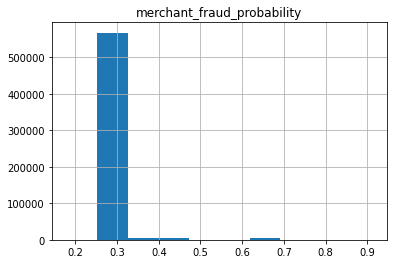

In [93]:
df.hist()

array([[<AxesSubplot:title={'center':'merchant_fraud_probability'}>]],
      dtype=object)

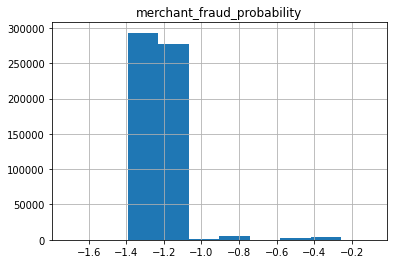

In [92]:
df.applymap(log).hist()

In [104]:
import pandas as pd

df = pd.read_csv(p('merchant_fraud_probability.csv', 'tables'))
df[df['merchant_abn'] == 27093785141]

,merchant_abn,order_datetime,fraud_probability
53,27093785141,2021-11-27,29.539473
55,27093785141,2021-11-29,29.520114
91,27093785141,2021-11-26,27.582358


22/10/03 20:41:21 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 2591150 ms exceeds timeout 120000 ms
22/10/03 20:41:21 WARN SparkContext: Killing executors is not supported by current scheduler.


In [100]:
fdf.where(F.col('merchant_abn') == 27093785141)

merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg,fraud_probability
27093785141,1195503,1,366.23,a8514aae-18fb-454...,2021-11-17,WA,6935,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0,0.029407407407407306
27093785141,712975,5,197.99,c61025aa-f92c-483...,2022-05-01,WA,6355,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.16599999999999998,4293,2976.0,75131.0,2.2358944E8,58036.0,46.0,0.04881629629629612
27093785141,845767,33,981.32,349490e1-63c5-46f...,2022-06-12,WA,6110,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.08,58432,29909.0,57434.333333333336,1.73471922E9,51185.0,39.666666666666664,0.023525925925925843
27093785141,845767,33,65.95,fc7468a4-b843-499...,2022-06-23,WA,6110,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.08,58432,29909.0,57434.333333333336,1.73471922E9,51185.0,39.666666666666664,0.023525925925925843
27093785141,1312921,88,151.08,990e9f67-ca65-447...,2022-09-20,SA,5018,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,null,15050,8074.0,59418.0,4.79740272E8,53618.0,45.0,null
27093785141,1312921,88,305.29,289cd9cb-4572-4cd...,2021-07-08,SA,5018,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,null,15050,8074.0,59418.0,4.79740272E8,53618.0,45.0,null
27093785141,254118,115,128.68,beb5fb34-64fb-43d...,2022-03-07,VIC,3687,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.125,4091,2336.0,53196.0,1.24265372E8,47557.0,48.0,0.03675925925925913
27093785141,254118,115,121.49,26be83ec-d379-482...,2022-06-18,VIC,3687,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.125,4091,2336.0,53196.0,1.24265372E8,47557.0,48.0,0.03675925925925913
27093785141,1005844,138,49.8,94d111d8-8ae7-47f...,2021-10-28,VIC,3415,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.134,10383,6216.0,68964.0,4.20819919E8,46705.0,50.0,0.03940592592592579
27093785141,1005844,138,278.43,99ae95b8-01eb-433...,2022-07-22,VIC,3415,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.134,10383,6216.0,68964.0,4.20819919E8,46705.0,50.0,0.03940592592592579


### 4. Experiments

In [22]:
import pandas as pd

c = pd.read_csv(p('consumer_fraud_probability.csv', 'tables'))
m = pd.read_csv(p('merchant_fraud_probability.csv', 'tables'))

In [174]:
m[m['merchant_abn'] == 18158387243]

,merchant_abn,order_datetime,fraud_probability
75,18158387243,2021-11-26,29.102419
80,18158387243,2021-11-29,28.956948


In [175]:
t = sdf.where(F.col('merchant_abn') == 18158387243)\
    .groupBy('order_datetime')\
    .agg({"dollar_value": "sum"})\

print(t.where(F.col('order_datetime') == '2021-11-26'), t.where(F.col('order_datetime') == '2021-11-29'))

+--------------+------------------+
|order_datetime| sum(dollar_value)|
+--------------+------------------+
|    2021-11-26|43349.899999999994|
+--------------+------------------+
 

+--------------+-----------------+
|order_datetime|sum(dollar_value)|
+--------------+-----------------+
|    2021-11-29|         43041.94|
+--------------+-----------------+



In [176]:
tdf = t.toPandas()

<AxesSubplot:xlabel='sum(dollar_value)'>

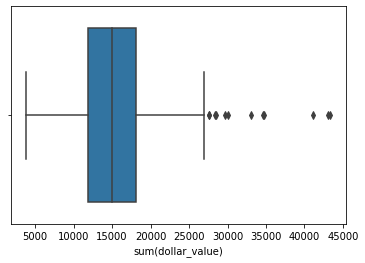

In [177]:
import seaborn as sns

sns.boxplot(data=tdf, x='sum(dollar_value)')

In [172]:
sdf.where(F.col('merchant_fraud_probability') < 0.3)

merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg
27093785141,1195503,1,366.23,a8514aae-18fb-454...,2021-11-17,WA,6935,Female,Placerat Orci Ins...,"stationery, offic...",c,2.73,retail_and_wholes...,others_retailing,0.29407407407407304,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0
50315283629,1195503,1,115.82,15aa1064-944f-4e5...,2021-11-13,WA,6935,Female,Iaculis Aliquet D...,lawn and garden s...,c,1.76,retail_and_wholes...,food_retailing,0.28488372093023295,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0
50315283629,1195503,1,63.88,c4e1da7a-39b5-49d...,2022-10-13,WA,6935,Female,Iaculis Aliquet D...,lawn and garden s...,c,1.76,retail_and_wholes...,food_retailing,0.28488372093023295,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0
18158387243,1195503,1,509.02,c2d04076-755f-4c2...,2022-10-16,WA,6935,Female,Nec Tellus Ltd,health and beauty...,c,2.03,others,null,0.2899999999999993,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0
21439773999,1195503,1,16.04,2bd9d9c7-8628-45e...,2022-07-12,WA,6935,Female,Mauris Non Institute,"cable, satellite,...",a,6.1,info_media_and_te...,null,0.2900000000000009,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0
21439773999,1195503,1,105.61,195a278f-c0b8-411...,2022-10-24,WA,6935,Female,Mauris Non Institute,"cable, satellite,...",a,6.1,info_media_and_te...,null,0.2900000000000009,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0
21439773999,1195503,1,37.28,abdca677-06d9-476...,2022-07-08,WA,6935,Female,Mauris Non Institute,"cable, satellite,...",a,6.1,info_media_and_te...,null,0.2900000000000009,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0
21439773999,1195503,1,188.12,bdd47d52-a63c-4ee...,2022-01-08,WA,6935,Female,Mauris Non Institute,"cable, satellite,...",a,6.1,info_media_and_te...,null,0.2900000000000009,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0
21439773999,1195503,1,28.74,a8843d2c-2b00-412...,2022-07-22,WA,6935,Female,Mauris Non Institute,"cable, satellite,...",a,6.1,info_media_and_te...,null,0.2900000000000009,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0
76767266140,1195503,1,44.53,2b537e37-66e9-4d3...,2022-02-06,WA,6935,Female,Phasellus At Limited,"furniture, home f...",b,4.65,retail_and_wholes...,household_goods_r...,0.2999999999999989,0.1,10636,5795.0,62144.0,3.60125906E8,52618.0,41.0


In [3]:
df = sdf\
    .select('user_fraud_probability', 'dollar_value', 'revenue', 'rate', 'subcategory')\
    .where(F.col('user_fraud_probability').isNotNull())\
    .sample(0.01)\
    .toPandas()

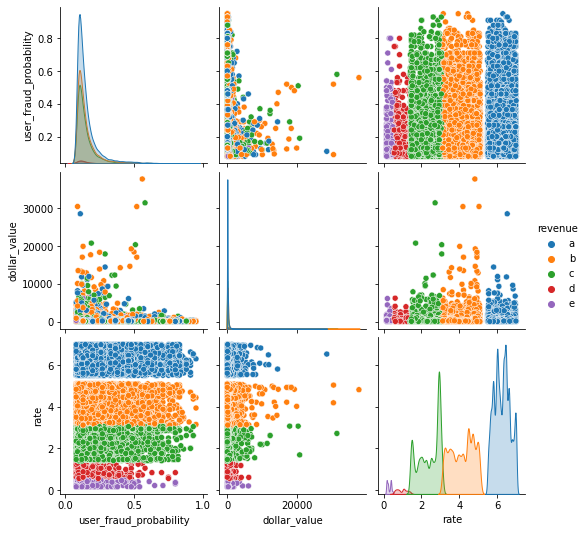

In [7]:
import seaborn as sns

sns.pairplot(data=df, hue='revenue')

<AxesSubplot:xlabel='revenue', ylabel='Count'>

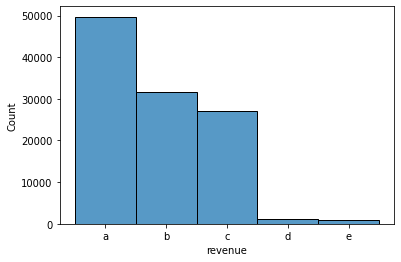

In [9]:
sns.histplot(data=df['revenue'])

In [23]:
m[m['merchant_abn'] == 14530561097]

,merchant_abn,order_datetime,fraud_probability
57,14530561097,2021-09-15,80.800545


22/10/04 22:57:18 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1729520 ms exceeds timeout 120000 ms
22/10/04 22:57:18 WARN SparkContext: Killing executors is not supported by current scheduler.


In [17]:
sdf.where(F.col('merchant_abn') == 14530561097).groupBy('')

merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,state,postcode,gender,merchant_name,tag,revenue,rate,category,subcategory,merchant_fraud_probability,user_fraud_probability,estimated_region_population_2021_sum,persons_earners_2018-19_sum,mean_earnings_2018-19_avg,sum_earnings_2018-19_sum,median_earnings_2018-19_avg,med_age_earners_2018-19_avg
14530561097,133056,1100,14941.48,ef46018e-0dea-488...,2022-06-22,QLD,4815,Male,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,0.12000000000000002,27211,13903.0,59204.0,8.04893118E8,53023.666666666664,42.333333333333336
14530561097,561903,1700,7057.2,a0411ea1-f9c1-465...,2021-05-17,WA,6419,Female,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,0.16,5156,2779.0,82957.0,2.30537667E8,55851.0,46.0
14530561097,756277,5265,11288.37,66b3ab05-6382-412...,2021-08-16,ACT,2903,Female,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,0.25,8905,6138.0,70460.0,4.33390733E8,62512.5,45.5
14530561097,847350,23339,11503.68,e31dc1f5-ebf7-4c6...,2022-05-30,SA,5083,Female,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,null,31052,16768.0,60393.5,9.14310663E8,51514.5,39.0
14530561097,1132848,3504,12243.89,cf273a12-e2b7-42f...,2021-11-14,NSW,2663,Female,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,0.35,36693,19165.0,51283.0,1.006367922E9,45415.5,45.75
14530561097,1060454,10025,12961.47,7cf2b2a1-6488-4c1...,2022-07-27,NSW,2234,Female,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,0.15,32155,20935.0,75037.5,1.563142026E9,60238.0,46.0
14530561097,1471040,13190,11470.57,496b96ee-298e-439...,2021-04-14,TAS,7179,Male,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,0.15399999999999997,2509,1208.0,41606.0,5.0260525E7,34924.0,53.0
14530561097,840522,19780,15750.28,f38dca7f-8edf-4e7...,2021-12-19,WA,6070,Female,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,0.52,7274,4544.0,75817.0,3.44512848E8,55002.0,48.0
14530561097,3357,22992,10315.83,04e57e4d-0acc-455...,2021-12-27,QLD,4815,Male,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,0.35,27211,13903.0,59204.0,8.04893118E8,53023.666666666664,42.333333333333336
14530561097,528259,781,13389.46,91ba30be-5771-442...,2021-05-13,QLD,4415,Male,Duis At Inc.,"jewelry, watch, c...",c,1.69,retail_and_wholes...,clothing_footwear...,0.81,0.28,4361,2222.0,43863.0,9.7463472E7,41616.0,44.0
